# A Simple Dynamic Model of Plastic Aggregation

# Introduction

Simulations are a powerful tool in computational science. A simulation is built using physical laws, like Newton's laws of motion, and then run to see how some system behaves, such as a mixture of microplastics. In this part of the activity, we will be playing with a very simple simulation that models the aggregation of plastic particles. Aggregation means that the plastics clump together rather than staying unbound and separate from each other. In this simulation, all plastic particles are spheres of the same size, and particles stick to each other any time they come in contact. Let's see what this simple model predicts about microplastic aggregation. Understanding plastic aggregation of microplastics can answer some important questions about microplastic behavior in the environment, such as:

    -Does microplastic pollution tend to aggregate or remain isolated?
    -How does the aggregation depend on the properties of the plastic and environmental conditions?
    -Does the aggregation tendency change as the plastic concentration increases?

Answering these question can help us understand where microplastics end up in the environment and may suggest ways to help remove microplastic pollution from the environment. The simple model we are using here won't be able to answer all of these questions, but will still provide some neat insights.

# The Program

Please run the below cell so we can run and visualize our simulations

In [8]:
import matplotlib.animation as animation
from matplotlib import pyplot as plt
from matplotlib.animation import HTMLWriter
import numpy as np

def p_v_init(num_particles, speed, R, L):
    
    #initial positions
    ps= np.zeros((num_particles,2))
    spacing = 1.2*2*R
    iters = int(L/spacing)
    count = 0
    flag = 0
    for i in range(iters):
        for j in range(iters):
            ps[count] = [i*spacing,j*spacing]
            count += 1
            if count == num_particles:
                flag = 1 
                break
        if flag == 1:
            break
    if flag == 0:
        print('too many particles to fit in system! Decrease N and try again')
        exit()
        
    ps = ps - L*0.5
    
    #initialize velocities
    theta = 2*np.pi*np.random.rand(num_particles)
    x_vs = speed*np.cos(theta)
    y_vs = speed*np.sin(theta)
    x_vs = np.reshape(x_vs, (num_particles,1))
    y_vs = np.reshape(y_vs, (num_particles,1))
    vs = np.concatenate((x_vs, y_vs), axis=1)
    return ps, vs

def calc_coll_time(ri, rj, vi, vj, L, D2):
    vij = vi-vj
    rij = (ri-rj) - L*np.round((ri-rj)/L) 
    rij2 = np.dot(rij, rij)
    
    #use quadratic formula to calculate collision time
    bij = np.dot(rij, vij)          
    
    if bij >= 0 : #particles not on correct trajectory to collide
        return np.Inf
    
    vij2 = np.dot(vij, vij)
    det = bij**2-(vij2)*(rij2-D2)
    vij2 = np.dot(vij, vij)
    if det < 0: #particles will not collide
        return np.Inf
    t_coll = (-bij-(det**.5))/(vij2)
    return t_coll 
    
def calc_coll_times_all(collision_times, ps, vs, num_particles, agg_indices, L, D2):
    for i in range(num_particles):
        for j in range(i+1, num_particles):
            if agg_indices[i] != agg_indices[j]:
                collision_times[i,j] = calc_coll_time(ps[i], ps[j], vs[i], vs[j], L, D2)
    return collision_times

def merge_shift_clusters(agg_indices, agg_array, agg_array_lens,agg_clusters, ind1, ind2):
    min_c = min(agg_indices[ind1],  agg_indices[ind2])
    max_c = max(agg_indices[ind1],  agg_indices[ind2])
    for i in range(len(agg_indices)):
        if agg_indices[i] == max_c:
            agg_indices[i] = min_c
        elif agg_indices[i] > max_c:
            agg_indices[i] = agg_indices[i] - 1
    agg_array[min_c, agg_array_lens[min_c] : agg_array_lens[min_c] + agg_array_lens[max_c]] = agg_array[max_c, 0 : agg_array_lens[max_c]]
    agg_array_lens[min_c] += agg_array_lens[max_c]
    agg_array_lens[max_c] = 0
    for i in range(max_c, agg_clusters-1):
        agg_array[i] = agg_array[i+1]
        agg_array_lens[i] = agg_array_lens[i+1]
    agg_array[agg_clusters-1] = 0
    agg_array_lens[agg_clusters-1] = 0

def collide(ps, vs, pair, t_coll, agg_array, agg_indices, num_agg, agg_clusters, agg_array_lens, L):
    #move everything up to time of collision
    ps = ps + t_coll * vs
    ps -= L*np.around(ps/L) 

    v_av = (agg_array_lens[agg_indices[pair[0]]]*vs[pair[0]] + agg_array_lens[agg_indices[pair[1]]]*vs[pair[1]]) \
        / (agg_array_lens[agg_indices[pair[0]]] + agg_array_lens[agg_indices[pair[1]]]) 
        
    v_av = np.sqrt((1.0/np.dot(v_av, v_av))) * v_av
  
    for i in range(agg_array_lens[agg_indices[pair[0]]]):
        vs[agg_array[agg_indices[pair[0]], i]] = v_av
    for i in range(agg_array_lens[agg_indices[pair[1]]]):
        vs[agg_array[agg_indices[pair[1]], i]] = v_av
    
    #merge clusters, and shift other cluster numbers as necessary
    merge_shift_clusters(agg_indices, agg_array, agg_array_lens, agg_clusters, pair[0], pair[1])
    agg_clusters -= 1
            
    return ps, vs, num_agg, agg_clusters
                        
def recalc_coll_times(pair, ps, vs, num_particles, ts_next_list, partners_list, agg_indices, L, D2):
    ts_next_list[pair[0]] = np.Inf
    ts_next_list[pair[1]] = np.Inf
    for i in range(num_particles):
        for j in pair:
            if agg_indices[i] != agg_indices[j]:
                t_coll = calc_coll_time(ps[i], ps[j], vs[i], vs[j], L, D2)
                if t_coll < ts_next_list[i]:
                    ts_next_list[i] = t_coll
                    partners_list[i] = j
                if t_coll < ts_next_list[j]:
                    ts_next_list[j] = t_coll
                    partners_list[j] = i

def min_ts_all(collision_times, num_particles):
    ts_next_list = np.zeros((num_particles,))
    partners_list = np.zeros((num_particles,),dtype=int)
    t_next = np.inf
    t_next_index = num_particles + 1
    for i in range(num_particles):
        arg_min = np.argmin(collision_times[i])
        ts_next_list[i] = collision_times[i,arg_min]
        partners_list[i] = arg_min
        if collision_times[i,arg_min] < t_next:
            t_next_index = i
            t_next = collision_times[i,arg_min]
    return ts_next_list, partners_list, t_next_index, t_next

def write_output(ps, num_particles, output_file, cur_t, agg_indices, agg_clusters):
    with open(output_file, 'a') as f:
        f.write(f'Time: {cur_t} Clusters: {agg_clusters}\n')
        for i in range(num_particles):
            f.write(f'{ps[i,0]:1.4f}   {ps[i,1]:1.4f}   {agg_indices[i]}\n')

def simulate(num_particles=20, T=1, seed=0):
    
    if T <= 0:
        print('T needs to be larger than 0! Please fix and retry')
        exit()
    elif T > 5:
        print('T needs to be smaller than 5! Please fix and retry')
        exit()
    L = 10
    speed = T
    R=0.2
    D2=(2*R)**2
    t_step = 1
    t_output = t_step/5
    t_total = 100*t_step
    output_file = 'Aggregate.txt'
    recalc_all_interval = 10
    
    np.random.seed(seed)
    #initialize positions and velocities
    ps, vs = p_v_init(num_particles, speed, R, L)
     
    #initialize aggregated particles
    agg_array = -1*np.ones((num_particles, num_particles), dtype=int)
    agg_array[:,0] = np.arange(0, num_particles)
    agg_array_lens = np.ones((int(np.ceil(num_particles)),), dtype=int)
    agg_indices = np.arange(0,num_particles)
    num_agg = 0
    agg_clusters = num_particles
    
    #find initial collision times
    coll_times = np.full((num_particles, num_particles), np.Inf)
    calc_coll_times_all(coll_times, ps, vs, num_particles, agg_indices, L, D2)
    ts_next_list, partners_list, t_next_index, t_next = min_ts_all(coll_times, num_particles)
    steps_til_recalc_all = recalc_all_interval
    
    #prep output file
    with open(output_file, 'w') as f:
        f.write('Running Simulation!\n')
        f.write(f'R: {R}\n')
    
    #do main loop
    cur_t = 0
    flag = 0
    time_til_output = t_output
    count = 0
    write_output(ps, num_particles, output_file, cur_t, agg_indices, agg_clusters)
    while(cur_t < t_total):
        if t_next < time_til_output:
            #perform collision
            pair = [t_next_index, partners_list[t_next_index]]
            ps, vs, num_agg, agg_clusters = collide(ps, vs, pair, t_next, agg_array, agg_indices, num_agg, agg_clusters, agg_array_lens, L)
            cur_t += t_next
            time_til_output -= t_next
            ts_next_list -= t_next
            
            #recalculate collision times for particles that just collided
            #t_next = np.Inf
            #t_next_index = num_particles + 1
            for i in range(num_particles):
                if i not in pair:
                    #First if:  particle was going to collide with either of the two particles that just collided, so update its time
                    #Second if: particle was going to collide with particle in new cluster formed, so update its time
                    #Third if:  particle was going to collide with particle now in its own cluster, so update its time
                    if partners_list[i] in pair or partners_list[i] > num_particles or  \
                    agg_indices[pair[0]] == agg_indices[partners_list[i]] or \
                    agg_indices[i] == agg_indices[partners_list[i]]:
                        pair.append(i)
                        ts_next_list[i] = np.Inf
                        partners_list[i] = num_particles+1
            recalc_coll_times(pair, ps, vs, num_particles, ts_next_list, partners_list, agg_indices, L, D2)
            
            #find next collision to happen
            t_next_index = np.argmin(ts_next_list)
            t_next = ts_next_list[t_next_index]
            
            #if all particles have aggregated, then terminate program
            if agg_clusters == 1:
                write_output(ps, num_particles, output_file, cur_t, agg_indices, agg_clusters)
                flag = 1
                print('All particles have aggregated, ending program!')
                break
            #check_overlap(ps, num_particles)
        
        else:
            count += 1
            ps = ps + time_til_output*vs
            ps -= L*np.around(ps/L) 
            cur_t += time_til_output
            ts_next_list -= time_til_output
            t_next -= time_til_output
            write_output(ps, num_particles, output_file, cur_t, agg_indices, agg_clusters)
            time_til_output = t_output
            #check_overlap(ps, num_particles)
            
            if count == recalc_all_interval:
                #periodically recalculate all collision times, since particle collision times only accurate for short time period
                coll_times = np.full((num_particles, num_particles), np.Inf)
                calc_coll_times_all(coll_times, ps, vs, num_particles, agg_indices, L, D2)
                ts_next_list, partners_list, t_next_index, t_next = min_ts_all(coll_times, num_particles)
                steps_til_recalc_all = recalc_all_interval
                count = 0
                    
    if flag == 0:
        print('Program finished normally!')

def analyze(infile='Aggregate.txt', Anim=True, AggPlot=True):

    x_lim = [-5, 5]
    y_lim = x_lim
    file = infile
    num_clusters = []
    times = [0]
    
    size = 0
    flag = 0
    with open(file,'r') as f:
        
        f.readline(); 
        vals = f.readline().split()
        r_plot = float(vals[1])/10 * 72 * 72 
        vals = f.readline().split()
        num_clusters.append(int(vals[-1]))
        for line in f:
            if line[0] == 'T':
                break
            elif flag == 0:
                size += 1
            
    if Anim:
        metadata = dict(title='Movie Test', artist='Matplotlib', comment='Movie support')
        writer = HTMLWriter(fps=20, metadata = metadata)  
        fig = plt.figure()
        fig.set_size_inches(5,5)
        #dpi = 100 #default value in matplotlib
        ax = plt.gca()
        ax.set_xlim(x_lim[0], x_lim[1])
        ax.set_ylim(y_lim[0], y_lim[1])
        ax.set_xticks(np.arange(x_lim[0], x_lim[1]+1))
        ax.set_yticks(np.arange(y_lim[0], y_lim[1]+1))
        locs = np.zeros((size,2))
        l = plt.scatter(locs[:,0], locs[:,1], s=r_plot)
        with open(file, 'r') as f:
            with writer.saving(fig, "writer_test.html", 100):
                f.readline()
                f.readline()
                f.readline()
                i = 0
                for line in f:
                    vals = line.split()
                    if i == size:
                      l.set_offsets(locs)
                      writer.grab_frame()
                      i = 0
                    else:
                        locs[i,:] = [float(val) for val in vals[0:2]]
                        i = i + 1
    if AggPlot:
        with open(file, 'r') as f:
            f.readline()
            f.readline()
            f.readline()
            i = 0
            for line in f:
                if line[0] == 'T':
                    vals = line.split()
                    times.append(float(vals[1]))
                    num_clusters.append(int(vals[-1]))
    
        fig2,ax2 = plt.subplots()
        ax2.plot(times, num_clusters)
        ax2.set_xlabel('Simulation Time')
        ax2.set_ylabel('Number of Clusters')
        ax2.set_title('Aggregation Behavior')

# Running Aggregation Simulations

Running a simulation is very simple - just run the cell below

In [ ]:
simulate()

All particles have aggregated, ending program!


You should have received the message "All particles have aggregated, ending program!". However, what actually happened? Let's call the analyze function to find out. This will generate two things: an animation showing how the trajectories of the plastics, and a plot showing the aggregation of the system. Here, we are describing the aggregation based on the number of clusters in the system. A cluster is any set of plastic particles that are contacting each other. We initially start with 20 clusters because there are a total of 20 particles in the system and no particles have aggregated yet. 

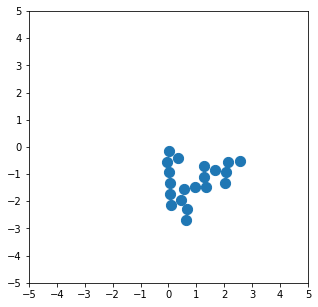

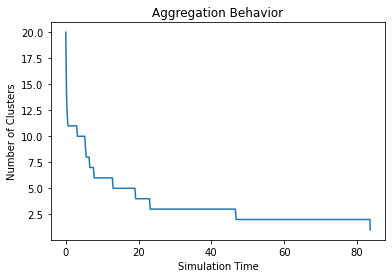

In [3]:
analyze()

The neat thing about simulations is that we can modify the parameters to understand how they influence aggregation. Today we will only play with three parameters: The number of particles in the system, the temperature of the system (which corresponds to how fast the particles move), and a _random seed_ which changes the initial velocities given to the particles at the beginning of the simulation. As we modify these variables, see if you can answer the following questions:

-Does changing the variable/parameter fundamentally change the behavior of the system?

-If the behavior does change, in what way does it change? Does aggregation go faster or slower? 

-If the behavior does or does not change, why do you think that is the case?

Let's begin by modifying the random seed: try a variety of seeds below and run the simulation. Testing different random seeds can be crucial in simulations to ensure the results are not dependent on the random numbers generated by a computer.

All particles have aggregated, ending program!


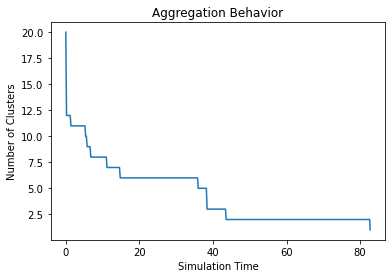

In [ ]:
seed = 10300 #change to any number you like and rerun the cell!
Anim=False #Change to "True" if you would also like to create the animation video
simulate(seed=seed)
analyze(Anim=Anim) 

Next let's change the number of particles in the system! As before, try a variety of values and run the cell below. You may also want to try changing the random seed again for a given number of particles to see how the behavior changes with different random seeds

NOTE: There is an upper limit to the number of particles that can be in the system, so please keep below 400 or else the program will give an error message

All particles have aggregated, ending program!


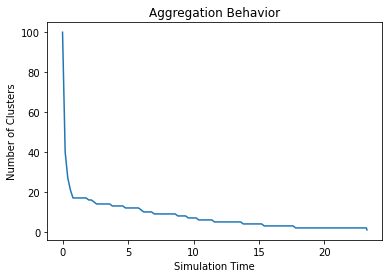

In [3]:
seed = 10300 #feel free to change the random seed again as well!
num_particles = 100 #keep this number below 400 or else particles can't fit in the system. 

Anim=False #Change to "True" if you would also like to create the animation video

simulate(seed=seed, num_particles=num_particles)
analyze(Anim=Anim)

Lastly, let's change the temperature of the system, which corresponds to how fast the particles are moving. As before, try changing the random seed and number of particles as well to see how all three variables interrelate.

T needs to be smaller than 5! Please fix and retry
All particles have aggregated, ending program!


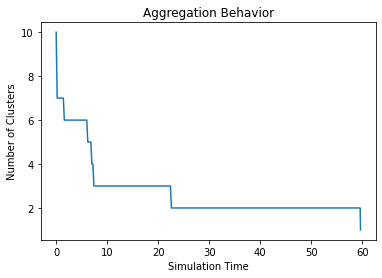

In [10]:
seed = 1000 #feel free to change the random seed again as well!
num_particles = 10 #keep this number below 400 or else particles can't fit in the system. 
T = 1 #keep this value below 5 so the particles don't move too fast

Anim=False #Change to "True" if you would also like to create the animation video

simulate(seed=seed, num_particles=num_particles, T=T)
analyze(Anim=Anim)

Now that you have investigated plastic aggregation in these simulations, try to answer the below questions. Test your hypothesis by running more simulations

-How does the number of particles affect the rate of aggregation?

-How does the system temperature affect the rate of aggregation?

-The difference between simulations with identical arguments except for the random seed corresponds to the expected variability in that system. How does increasing the number of particles or temperature affect the variability between simulations?

You have now successfully run and analyzed a simulation of plastic aggregation! As we conclude, it is very important to emphasize that our simulations are based on a model, which inherently is a simplified version of real life. Because the model contains assumptions and simplifications, it is not guaranteed to accurately reproduce actual microplastic aggregation. This makes it crucial for those designing a simulation to ensure that the program accurately captures the behavior they are studying. With this in mind, please answer the below questions:

    What do you think are some simplifications that this model makes?
    
    How could these simplifications be changed to more accurately reflect real life?